In [432]:
import pandas as pd
import numpy as np

# Importing Data

In [433]:
df = pd.read_csv(
    r'C:\Users\jross\Google Drive\Insight\interview prep\data_challenges\19B\data_challenge_1\breast-cancer-wisconsin.csv',
    header=None
)

In [434]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Looks like the columns are unnamed. Let's define and set them from the readme.md description.

In [435]:
columns = [
    'id',
    'Clump Thickness',
    'Uniformity of Cell Size',
    'Uniformity of Cell Shape',
    'Marginal Adhesion',
    'Single Epithelial Cell Size',
    'Bare Nuclei',
    'Bland Chromatin',
    'Normal Nucleoli',
    'Mitoses',
    'Class'
]

In [436]:
df.columns = [x.replace(' ','_') for x in columns]

# Cleaning Data

1. Should we drop ID column? Let's first check if there's duplicate IDs to prevent data leakage later when we split for training and test set.

In [437]:
duplicate_ids = df.id.value_counts()[df.id.value_counts()>1].index
duplicate_ids

Int64Index([1182404, 1276091, 1198641,  466906, 1116116, 1070935,  385103,
            1293439, 1240603, 1277792, 1168736,  560680, 1174057,  822829,
             320675,  897471, 1114570, 1339781,  654546,  704097, 1017023,
             734111, 1354840,  769612,  411453, 1158247, 1321942, 1061990,
             733639, 1218860, 1115293, 1238777, 1212422, 1100524, 1033078,
            1171710, 1299596, 1173347, 1299924, 1143978, 1320077,  493452,
             695091, 1116192,  798429, 1105524],
           dtype='int64')

Several duplicate ids. Let's drop these rows in case they cause data leakage. But first let's see the Class balance before this.

In [438]:
df.Class.value_counts()

2    458
4    241
Name: Class, dtype: int64

In [439]:
df = df[~df['id'].isin(duplicate_ids)]

No let's drop the id column since it's not useful for training.

In [440]:
df = df.drop(columns=['id'])

2. Class only has two options, benign (2) and malignant (4). So let's rescale these to 0 and 1 for our classification models

In [441]:
df.Class = ((df.Class-2)/2).astype(int)

In [442]:
df.Class.value_counts()

0    374
1    225
Name: Class, dtype: int64

Looks like most of the dropped ids were in the benign class and so if anything we have an even more balanced dataset now.

3. Check that data is all numeric

In [443]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 696
Data columns (total 10 columns):
Clump_Thickness                599 non-null int64
Uniformity_of_Cell_Size        599 non-null int64
Uniformity_of_Cell_Shape       599 non-null int64
Marginal_Adhesion              599 non-null int64
Single_Epithelial_Cell_Size    599 non-null int64
Bare_Nuclei                    599 non-null object
Bland_Chromatin                599 non-null int64
Normal_Nucleoli                599 non-null int64
Mitoses                        599 non-null int64
Class                          599 non-null int32
dtypes: int32(1), int64(8), object(1)
memory usage: 49.1+ KB


Bare_Nuclei is not all integers like the rest. Let's see what's going on there.

In [444]:
df.Bare_Nuclei.value_counts()

1     326
10    122
3      27
5      27
2      26
8      18
4      18
?      15
7       8
9       8
6       4
Name: Bare_Nuclei, dtype: int64

There's missing data indicated by '?'s. If we use Bare_Nuclei in the model, we'll need to fill in these missing values. For now let's choose to fill it in with the median Bare_Nuclei value

In [445]:
median = df.Bare_Nuclei[df.Bare_Nuclei!='?'].astype(int).median()
median

1.0

In [446]:
df.Bare_Nuclei = df.Bare_Nuclei.replace('?',median).astype(int)

In [447]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 696
Data columns (total 10 columns):
Clump_Thickness                599 non-null int64
Uniformity_of_Cell_Size        599 non-null int64
Uniformity_of_Cell_Shape       599 non-null int64
Marginal_Adhesion              599 non-null int64
Single_Epithelial_Cell_Size    599 non-null int64
Bare_Nuclei                    599 non-null int32
Bland_Chromatin                599 non-null int64
Normal_Nucleoli                599 non-null int64
Mitoses                        599 non-null int64
Class                          599 non-null int32
dtypes: int32(2), int64(8)
memory usage: 46.8 KB


All rows have integer values now

4. Now finally, check for nans.

In [448]:
len(df)-len(df.dropna(how='any'))

0

Looks like we have no Nan values. Data should be ready for analysis

# EDA and feature Selection

In [449]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Exploring feature correlations

## Remove redundant feature types

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


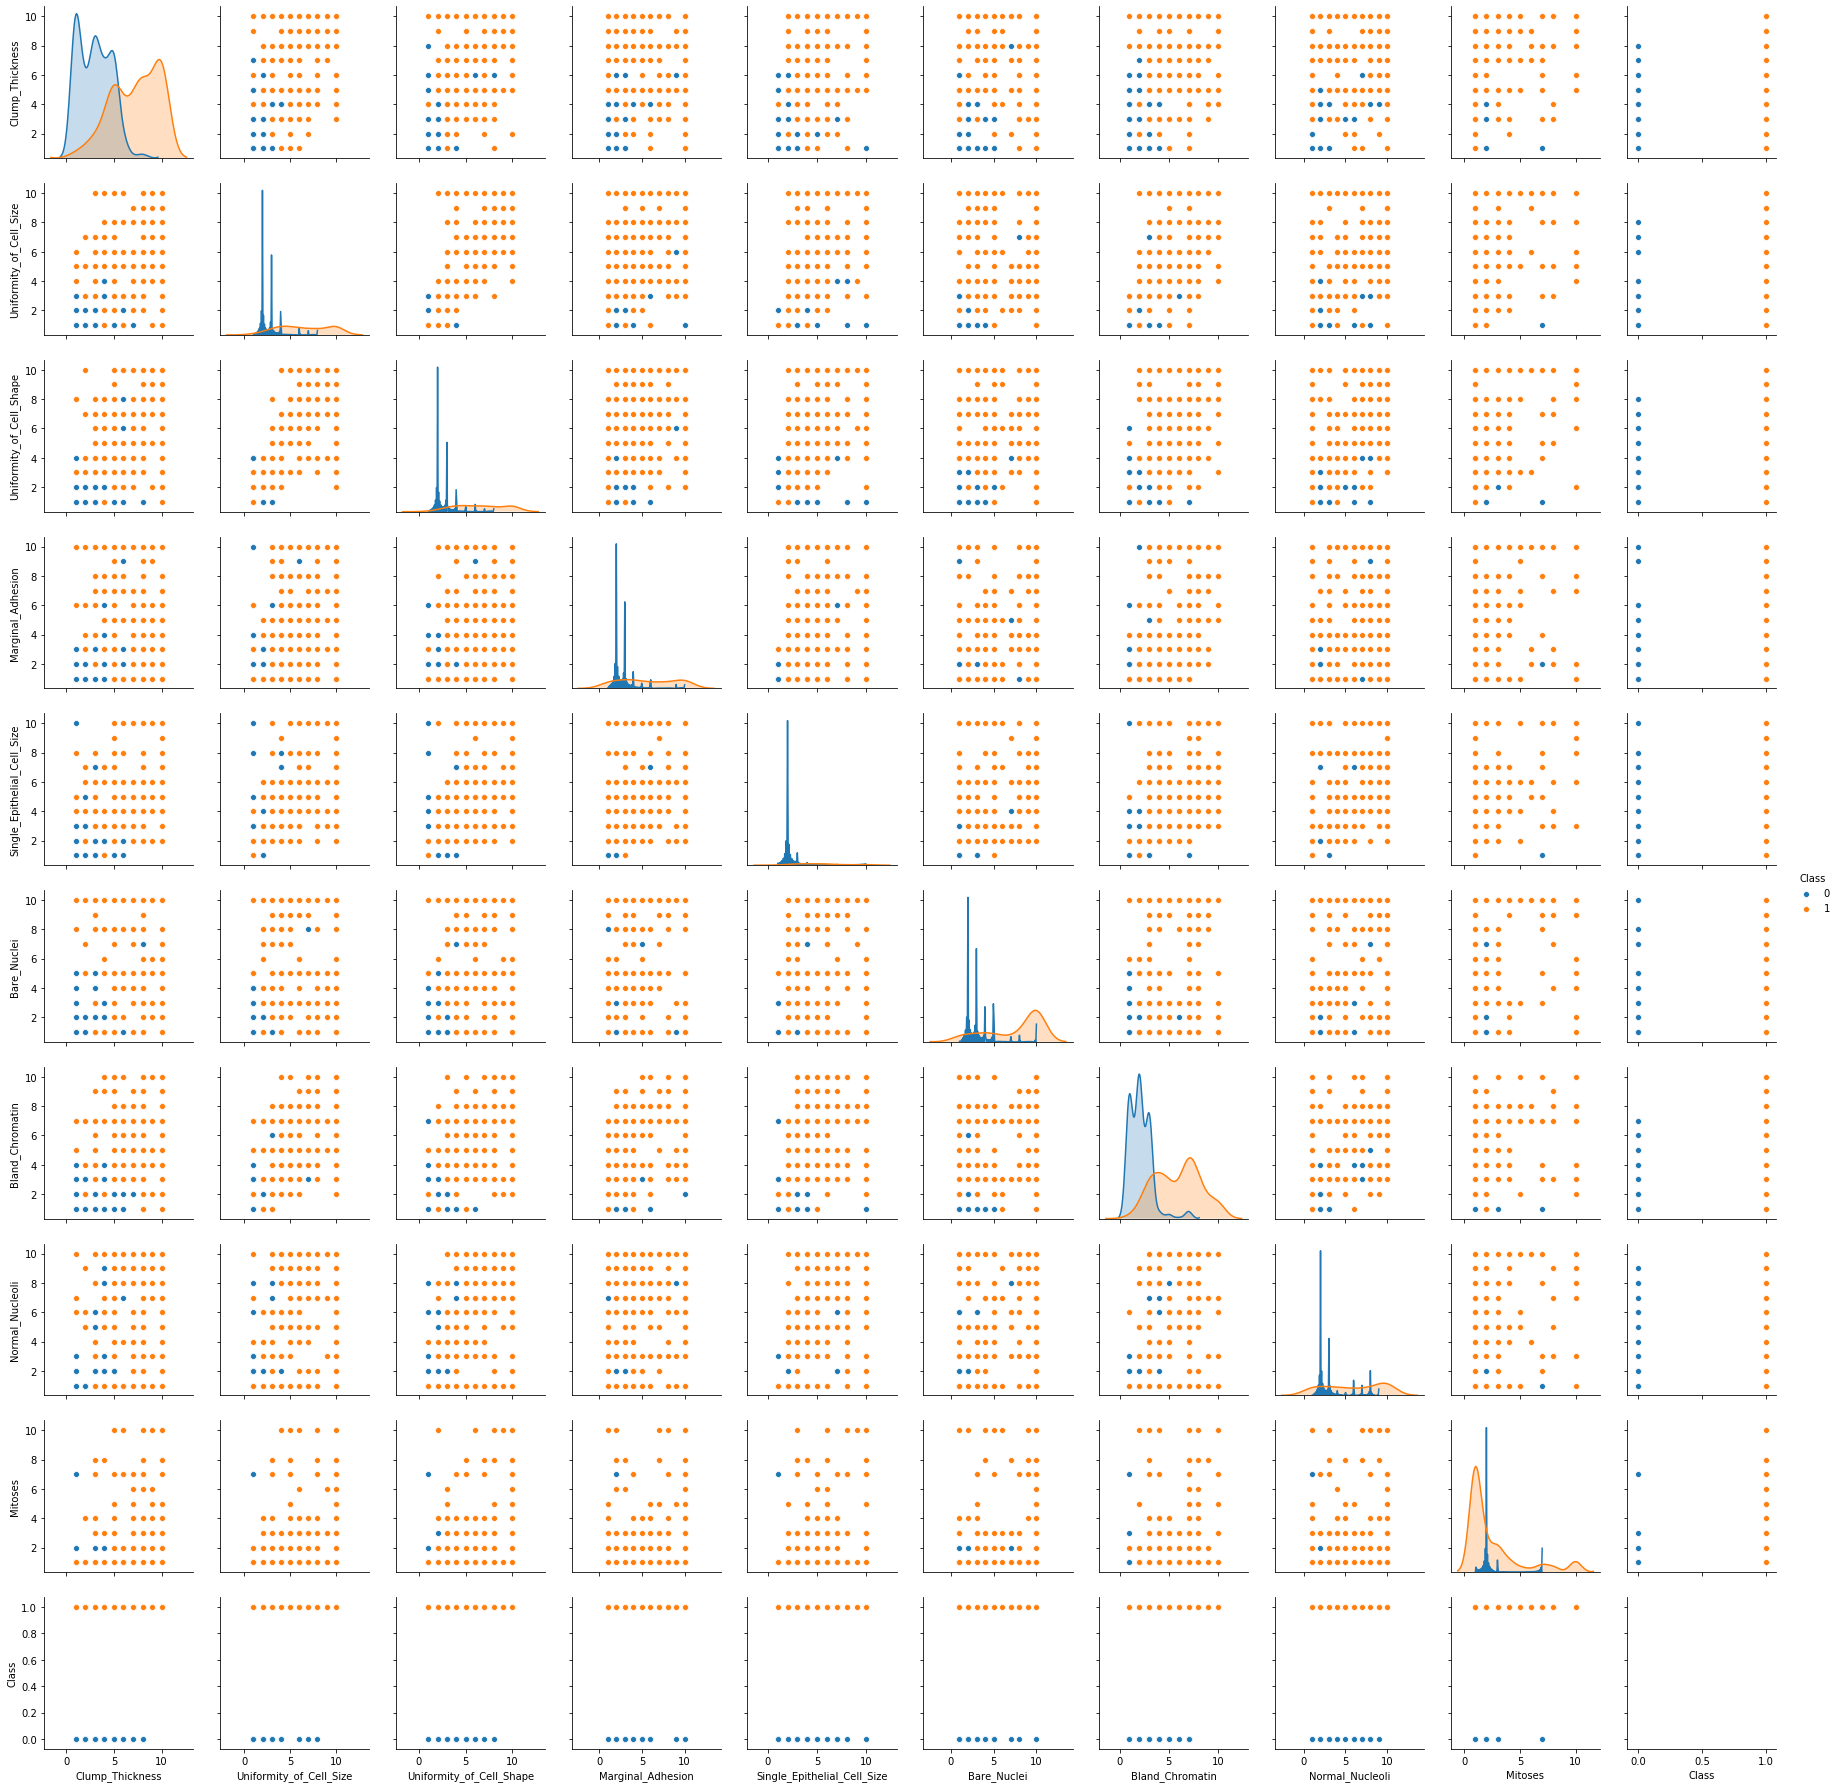

In [450]:
# plot correlation matrix for all columns, colored by Class.
sns.pairplot(data = df, hue = 'Class')

Seems to be a correlation between Uniformity of Cell Size and Uniformity of Cell Shape, which is maybe not too surprising. Let's see how strong the correlations are using a Pearson test and matrix plot.

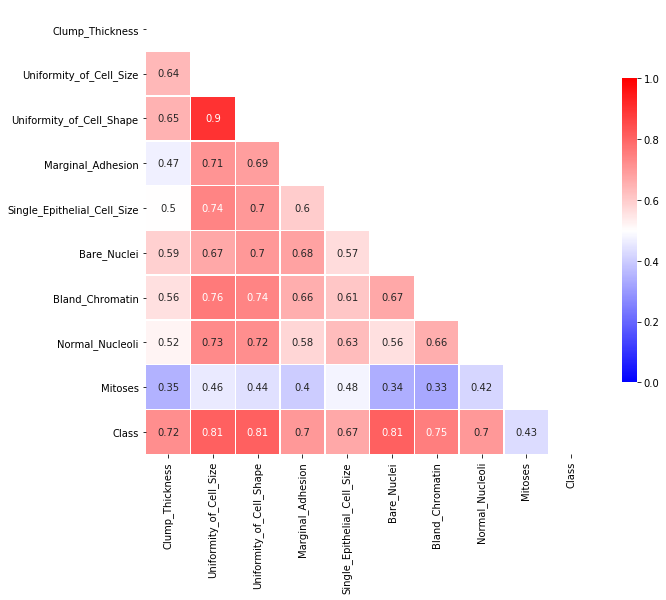

In [451]:
corr = df.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap='bwr', vmin=0, vmax=1, center = 0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

The Uniformity of Cell Shape and Size have a pretty strong Pearson coef of .91. I think it's safe to drop one of these going forward. Let's drop Uniformity of Cell Size since we already track cell thickness with another feature.

In [452]:
df = df.drop(columns=['Uniformity_of_Cell_Size'])

## Removing Non-discriminitory Features

In [453]:
melted = pd.melt(df,id_vars=['Class'],value_vars=df.columns[:-1])

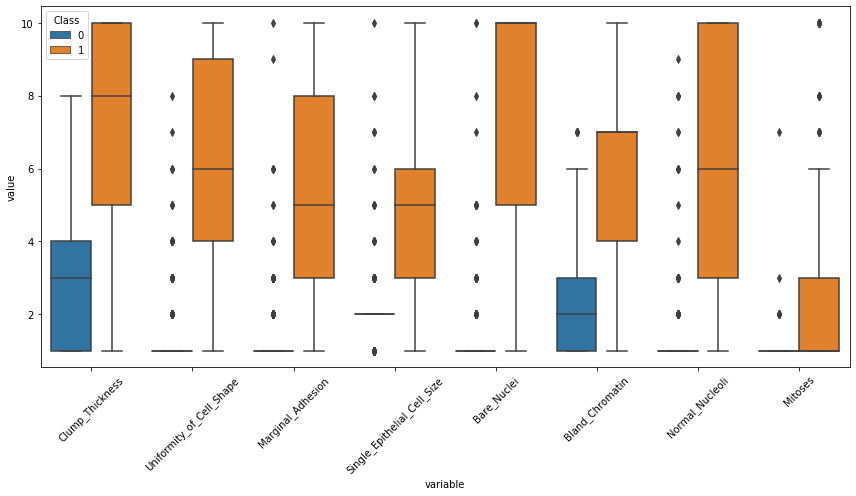

In [454]:
f, ax = plt.subplots(figsize=(12, 7))
p = sns.boxplot(x="variable", y="value", hue="Class", data=melted)
p.set_xticklabels(p.get_xticklabels(), rotation=45)
plt.tight_layout()

The remaining features all seem to be relatively discriminatory for the class labels, many of which have very tight distributions for the benign label.

I don't see a reason to drop any more features.

# Splitting data into train and test sets

In [455]:
from sklearn.model_selection import train_test_split

In [456]:
train_df, test_df = train_test_split(df, test_size = .1, stratify=df.Class, random_state = 1)

With only 669 rows of data, we don't want the train size to be too small so 90% seemed like a good choice.
Also the statify option was used to ensure train and test sets had same ratio of class labels, as confirmed below

In [457]:
train_df.Class.value_counts(normalize=True)

0    0.625232
1    0.374768
Name: Class, dtype: float64

In [458]:
test_df.Class.value_counts(normalize=True)

0    0.616667
1    0.383333
Name: Class, dtype: float64

# Predicting Breast Cancer

## Preparing the data for training and testing
we split the train and test into features and target arrays

In [459]:
features = train_df.columns.drop('Class')
train_X, train_y = train_df[features], train_df['Class']
test_X, test_y = test_df[features], test_df['Class']

## Fit Logistic Regression model 
This is a straightforward single category classification problem so it will be good to start with a Logistic Regression model and have it to compare to later models as we find the best

In [411]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluating the Model

### Accuracy, Precision, and Recall

In [412]:
# error and accuracy of model
from sklearn import metrics

def model_metrics(test_data, test_labels, model):
    pred = model.predict(test_data)
    print('Accuracy: {:.2f}'.format(metrics.accuracy_score(test_labels, pred)))
    print('Precision: {:.2f}'.format(metrics.precision_score(test_labels, pred)))
    print('Recall: {:.2f}'.format(metrics.recall_score(test_labels, pred)))

The test set metrics are:

In [479]:
s = time.time()
model_metrics(test_X, test_y, logreg)
f = time.time()
print('time',f-s)

Accuracy: 0.92
Precision: 0.88
Recall: 0.91
time 0.006517648696899414


Wow these are extremely good results for the first try. Let's check against the training data...

In [414]:
model_metrics(train_X, train_y, logreg)

Accuracy: 0.97
Precision: 0.97
Recall: 0.96


Similar results and if anything test predictions are better than training. 

### ROC Curve

Let's also generate the ROC curve for good measure

In [415]:
from sklearn.metrics import roc_curve

def plot_roc(test_data, test_labels, model):
    pred_prob = model.predict_proba(test_data)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true = test_y.values.ravel(), y_score = pred_prob, pos_label=1)
    plt.figure(figsize=(10,8))
    plt.plot(fpr,tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    print('AUC score of model on test set: {:.2f}'.format(metrics.roc_auc_score(test_labels, pred_prob)))

AUC score of model on test set: 0.98


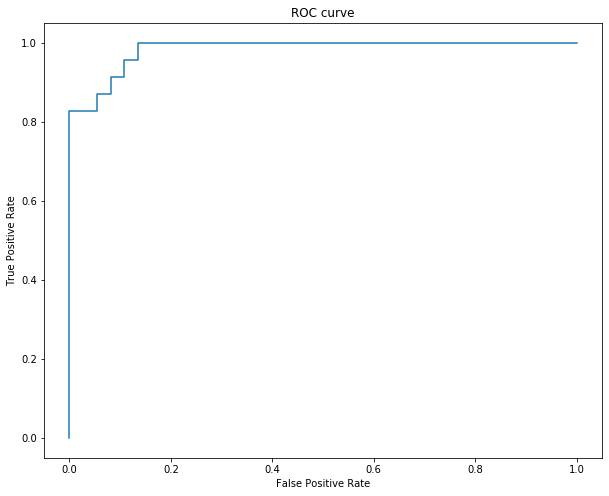

In [416]:
plot_roc(test_X, test_y, logreg)

Which is about as good as it gets for a classifier. 

I don't see much reason to explore other models at this point but one thing we can try to do is **maximize recall** because for a situation like predicting cancer, we want to **minimize false negatives.**

## Fit GaussianNB

In [460]:
from sklearn.naive_bayes import GaussianNB

In [461]:
nb = GaussianNB()
nb.fit(train_X,train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [463]:
import time

In [485]:
s = time.time()
model_metrics(test_X, test_y, nb)
f = time.time()

print('time',f-s)

Accuracy: 0.92
Precision: 0.85
Recall: 0.96
time 0.006517648696899414


## Maximizing Recall with GridSearchCV

In [417]:
from sklearn.model_selection import GridSearchCV

In [418]:
hyperparameters = {
    'C':np.linspace(0.01,1,500)
}

In [419]:
logreg_gridcv = LogisticRegression(solver='lbfgs', max_iter=10000)

clf = GridSearchCV(logreg_gridcv, hyperparameters, cv=5, verbose=0, scoring='recall')
best_model = clf.fit(train_X, train_y)
print('Best C:\n', best_model.best_estimator_.get_params()['C'])

Best C:
 0.02190380761523046


In [420]:
logreg_better = LogisticRegression(
    C = best_model.best_estimator_.get_params()['C'],
    max_iter=10000,
    solver='lbfgs'
)
logreg_better.fit(train_X, train_y)
print('New Test Set Metrics')
model_metrics(test_X, test_y, logreg_better)

New Test Set Metrics
Accuracy: 0.92
Precision: 0.88
Recall: 0.91


In [421]:
print('New Training Set Metrics')
model_metrics(train_X, train_y, logreg_better)

New Training Set Metrics
Accuracy: 0.97
Precision: 0.96
Recall: 0.96


OK. We were able to bump the recall up by .01 for the test data with hyperparameter tuning. No need to generate ROC, it's going to look basically the same.

## Boosting Recall with decision threshold tuning

one more thing we can do to boost the recall, at the expense of accuracy, is to change our class decision boundary away from the default of 0.5 for logistic regression probability predictions. This can be done using predict_proba and then manually assigning our labels with a custom threshold such as:

In [422]:
pred = (logreg_better.predict_proba(test_X) >= 0.3).astype(int)[:,1]
print('Metrics for test set with a decision threshold of 0.3')
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(test_y, pred)))
print('Precision: {:.2f}'.format(metrics.precision_score(test_y, pred)))
print('Recall: {:.2f}'.format(metrics.recall_score(test_y, pred)))

Metrics for test set with a decision threshold of 0.3
Accuracy: 0.90
Precision: 0.84
Recall: 0.91


Let's define a function to return the recall given a threshold

In [423]:
def recall_of_treshold(model, data, label, threshold):
    pred = (logreg_better.predict_proba(data) >= threshold).astype(int)[:,1]
    return metrics.recall_score(label, pred)

In [424]:
thresholds = np.linspace(.01,1,1000)
recalls = np.array([recall_of_treshold(logreg_better, train_X, train_y, x) for x in thresholds])
max_recall_idx = (len(recalls[recalls==recalls.max()])-1)
best_threshold = thresholds[max_recall_idx]
print('The best threshold for maximum recall is: ',best_threshold)

The best threshold for maximum recall is:  0.233963963963964


Let's see our metrics when we use this threshold

In [425]:
pred_test = (logreg_better.predict_proba(test_X) >= best_threshold).astype(int)[:,1]
print('Metrics for the Test Set')
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(test_y, pred_test)))
print('Precision: {:.2f}'.format(metrics.precision_score(test_y, pred_test)))
print('Recall: {:.2f}'.format(metrics.recall_score(test_y, pred_test)))

Metrics for the Test Set
Accuracy: 0.92
Precision: 0.85
Recall: 0.96


In [426]:
pred = (logreg_better.predict_proba(train_X) >= best_threshold).astype(int)[:,1]
print('Metrics for the Train Set')
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(train_y, pred)))
print('Precision: {:.2f}'.format(metrics.precision_score(train_y, pred)))
print('Recall: {:.2f}'.format(metrics.recall_score(train_y, pred)))

Metrics for the Train Set
Accuracy: 0.98
Precision: 0.95
Recall: 1.00


Excellent. We've achieved perfect recall on both data sets with some expense to accuracy and precision.

# Conclusion

To achieve this cancer classifier with high recall we:

1. Dropped one feature that had a high correlation to another
2. Used GridSearchCV to tune our C hyperparameter
3. Found an ideal logistic decision threshold that maximized Recall.

The resulting classifier has perfect recall for both training and test sets. Recall is important when predicting cancer because we would rather make false positives than false negatives. 

# Backup Cells

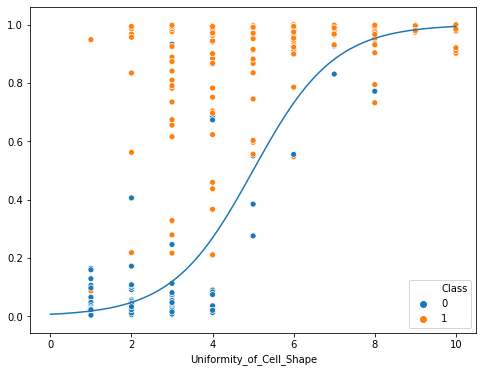

In [328]:
pred_proba = logreg_better.predict_proba(train_X)[:,1]
f = plt.figure(figsize=(8,6))
sns.scatterplot( x = train_X['Uniformity_of_Cell_Shape'], y =  pred_proba,hue = train_y)
sigmoid_x = np.linspace(-5,5,1000)
sigmoid_y = 1/(1+np.exp(-1*sigmoid_x))
sns.lineplot(x = sigmoid_x+5,y = sigmoid_y)

AUC score of model on test set: 0.98


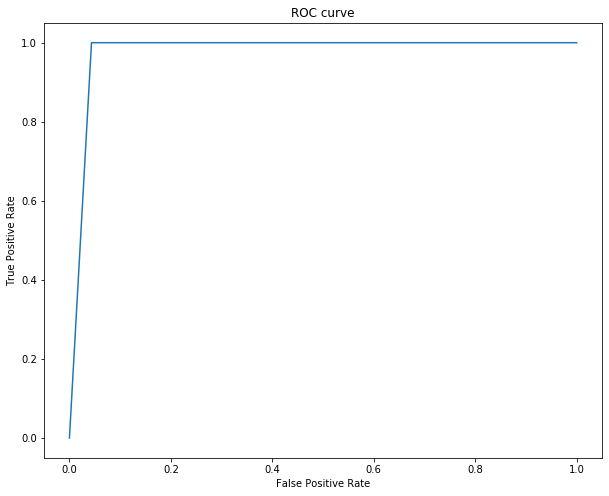

In [333]:
fpr, tpr, thresholds = roc_curve(y_true = test_y.values.ravel(), y_score = pred_test, pos_label=1)
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
print('AUC score of model on test set: {:.2f}'.format(metrics.roc_auc_score(test_y, pred_test)))